## Importing the libraries 

In [2]:
# Importing required libraries
import pandas as pd
import numpy as np
from numpy.random import seed
seed(123)
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
from IPython.display import SVG
from statsmodels.tsa.seasonal import seasonal_decompose
import geopandas as gpd
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from sklearn.feature_extraction.text import CountVectorizer
import datetime

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
from scipy import stats
from dateutil import parser
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Change pandas viewing options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

/Users/yingli/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Importing the data 

In [150]:
%%time
#! rm -r data.insideairbnb.com
# DC data:
! wget -xq http://data.insideairbnb.com/united-states/dc/washington-dc/2020-09-21/data/reviews.csv.gz
! wget -xq http://data.insideairbnb.com/united-states/dc/washington-dc/2020-02-22/data/reviews.csv.gz
! du -sh data.insideairbnb.com

Illegal variable name.
Illegal variable name.
Illegal variable name.
 72M	data.insideairbnb.com
CPU times: user 50.7 ms, sys: 51 ms, total: 102 ms
Wall time: 3.21 s


In [4]:
sep_path = './united-states/dc/washington-dc/2020-09-21/data/'
sep_reviews =  pd.read_csv(sep_path + 'reviews.csv.gz')

In [5]:
feb_path = './united-states/dc/washington-dc/2020-02-22/data/'
feb_reviews =  pd.read_csv(feb_path + 'reviews.csv.gz')

In [6]:
sep_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,3686,131293,2010-11-01,257234,Callie,Staying with Levita and her wonderful family w...
1,3686,150766,2010-12-08,255888,Patrick,"Vita is a very welcoming, helpful and friendly..."
2,3686,177749,2011-02-02,366688,Benjamin,"This was my first time using ""airbnb"" and it m..."
3,3686,197451,2011-03-12,213492,T.J.,"First, Vita saved my work week by providing me..."
4,3686,213212,2011-03-30,428455,Pete & Leila,Great host! Very welcoming and organised. I st...


In [7]:
sep_reviews.date = pd.to_datetime(sep_reviews.date) 
sep_reviews['day_of_year'] = sep_reviews['date'].dt.dayofyear

### Changes of the number of reviews over the years? 

Question 1: How does the number of reviews changes over the years? 

Answer: 
* number of reviews shows the strong seasonal cycle peaks in March-Apr-May
* strong weakly cycle, as most of the listings are booked for weekends, and reviews are submitted on weekends
* drop to almost zero, indicuting no booking after the lockdown

If we assume the 50% of the peopole leave the review comments, the number of review is a good indicator of the booking

Since the number of reviews decrease after the lockdown, in order to have a relatively complete list of the reviews, the 2020/02 review data will be used for statistics and sentimental analysis later. 

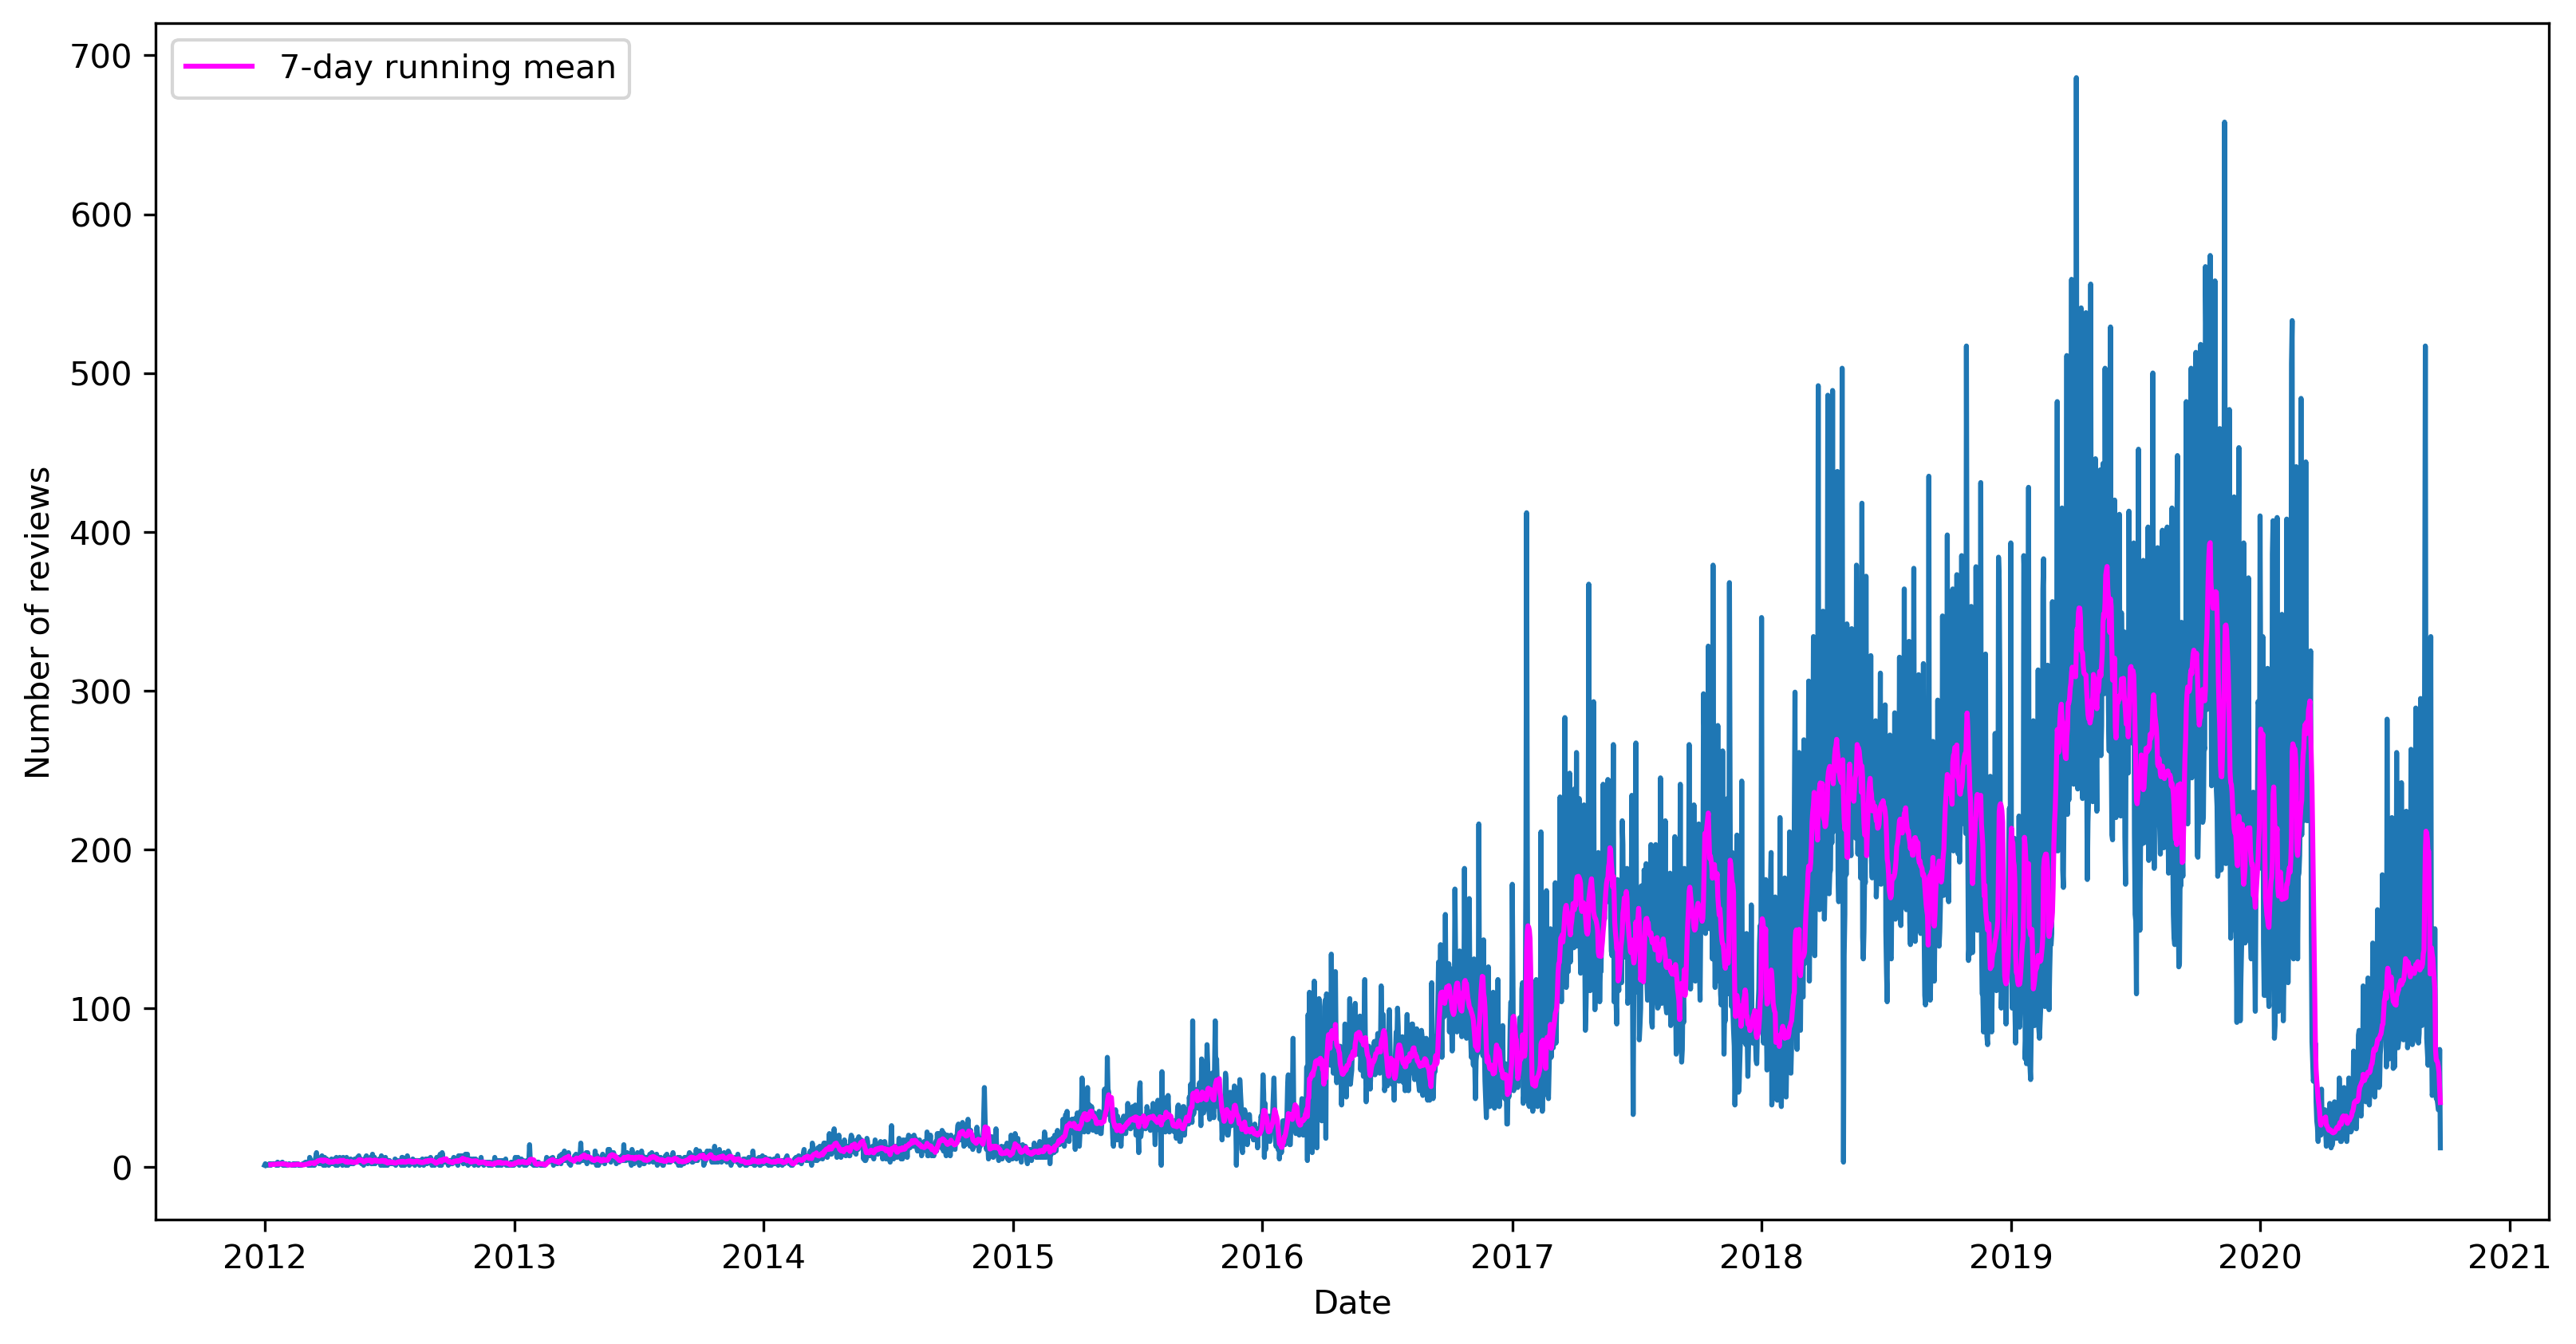

In [8]:
counts_of_day = sep_reviews.drop('listing_id',axis=1).groupby('day_of_year').count()
counts_of_date = sep_reviews.drop(['listing_id','day_of_year'],axis=1).groupby('date').count()

fig = plt.figure(figsize=(10,5),dpi=300)
ax = fig.add_axes([0,0,1,1])
ax.plot(counts_of_date['comments'].loc['2012-01-01':'2020-09-21'], label='')
ax.plot(counts_of_date['comments'].loc['2012-01-01':'2020-09-21'].rolling(window=7).mean(), label='7-day running mean', color='magenta')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Number of reviews');
fig.savefig('number_of_reviews.png', bbox_inches='tight')

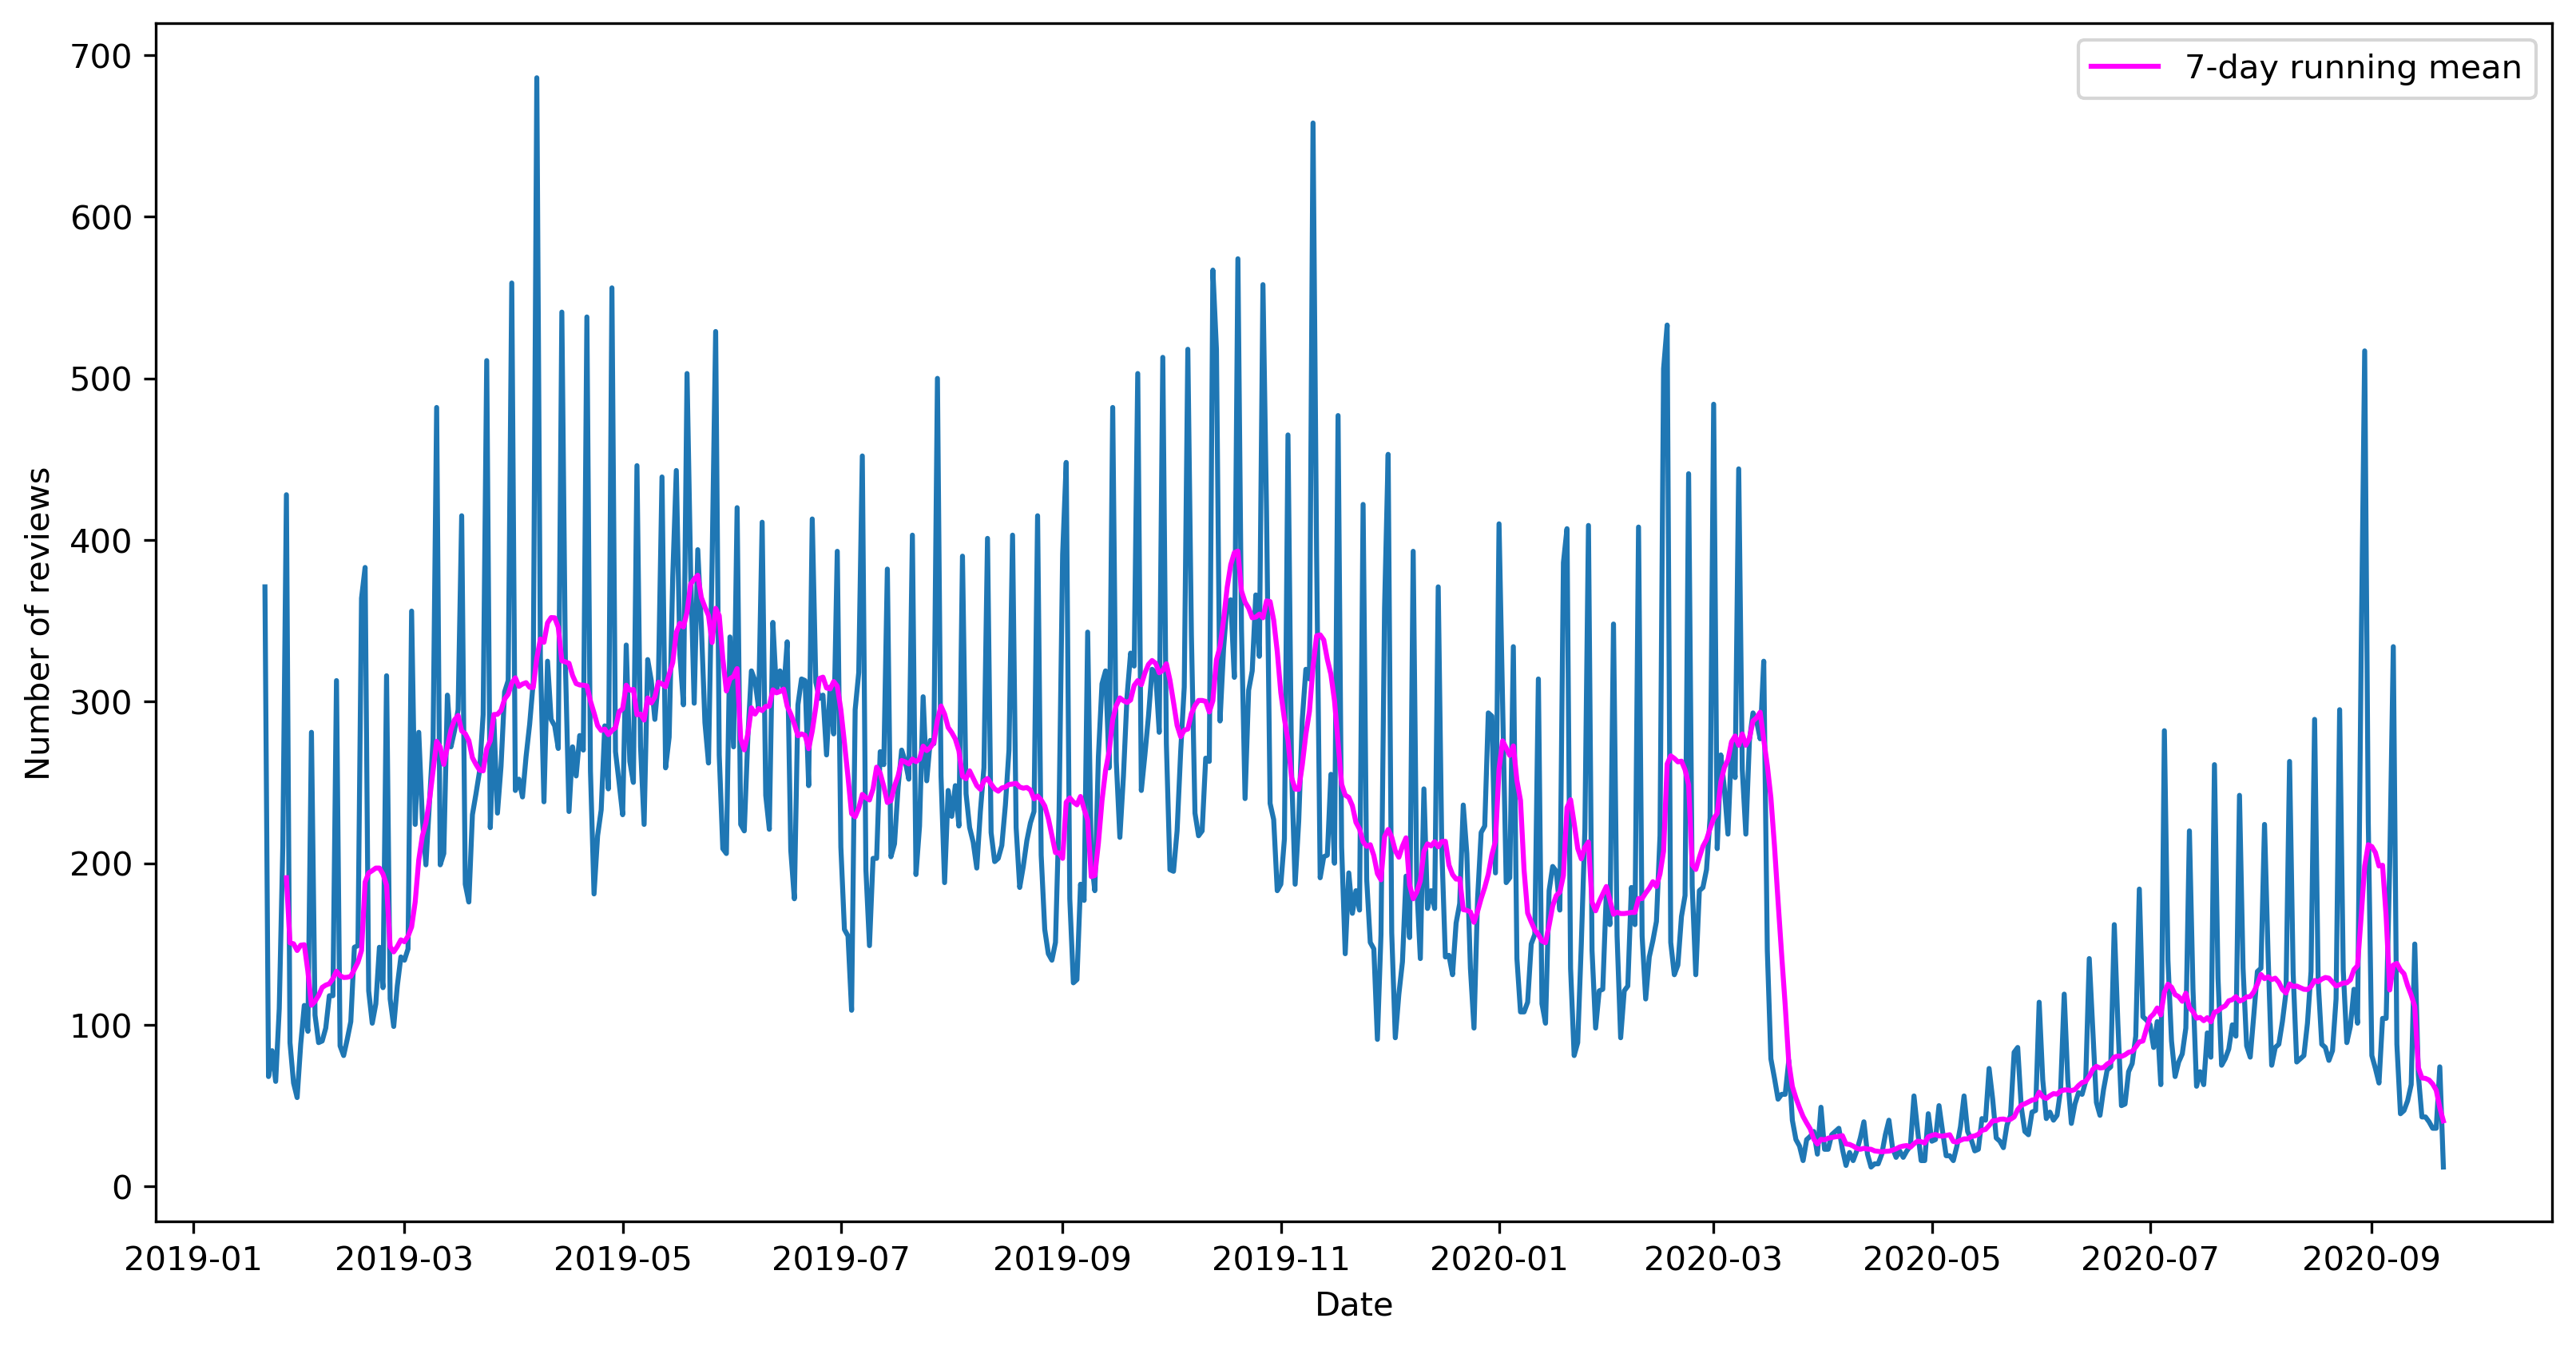

In [9]:
fig = plt.figure(figsize=(10,5),dpi=300)
ax = fig.add_axes([0,0,1,1])
ax.plot(counts_of_date['comments'].loc['2019-01-21':'2020-09-21'], label='')
ax.plot(counts_of_date['comments'].loc['2019-01-21':'2020-09-21'].rolling(window=7).mean(), label='7-day running mean', color='magenta')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Number of reviews');
fig.savefig('number_of_reviews_1yr.png', bbox_inches='tight')

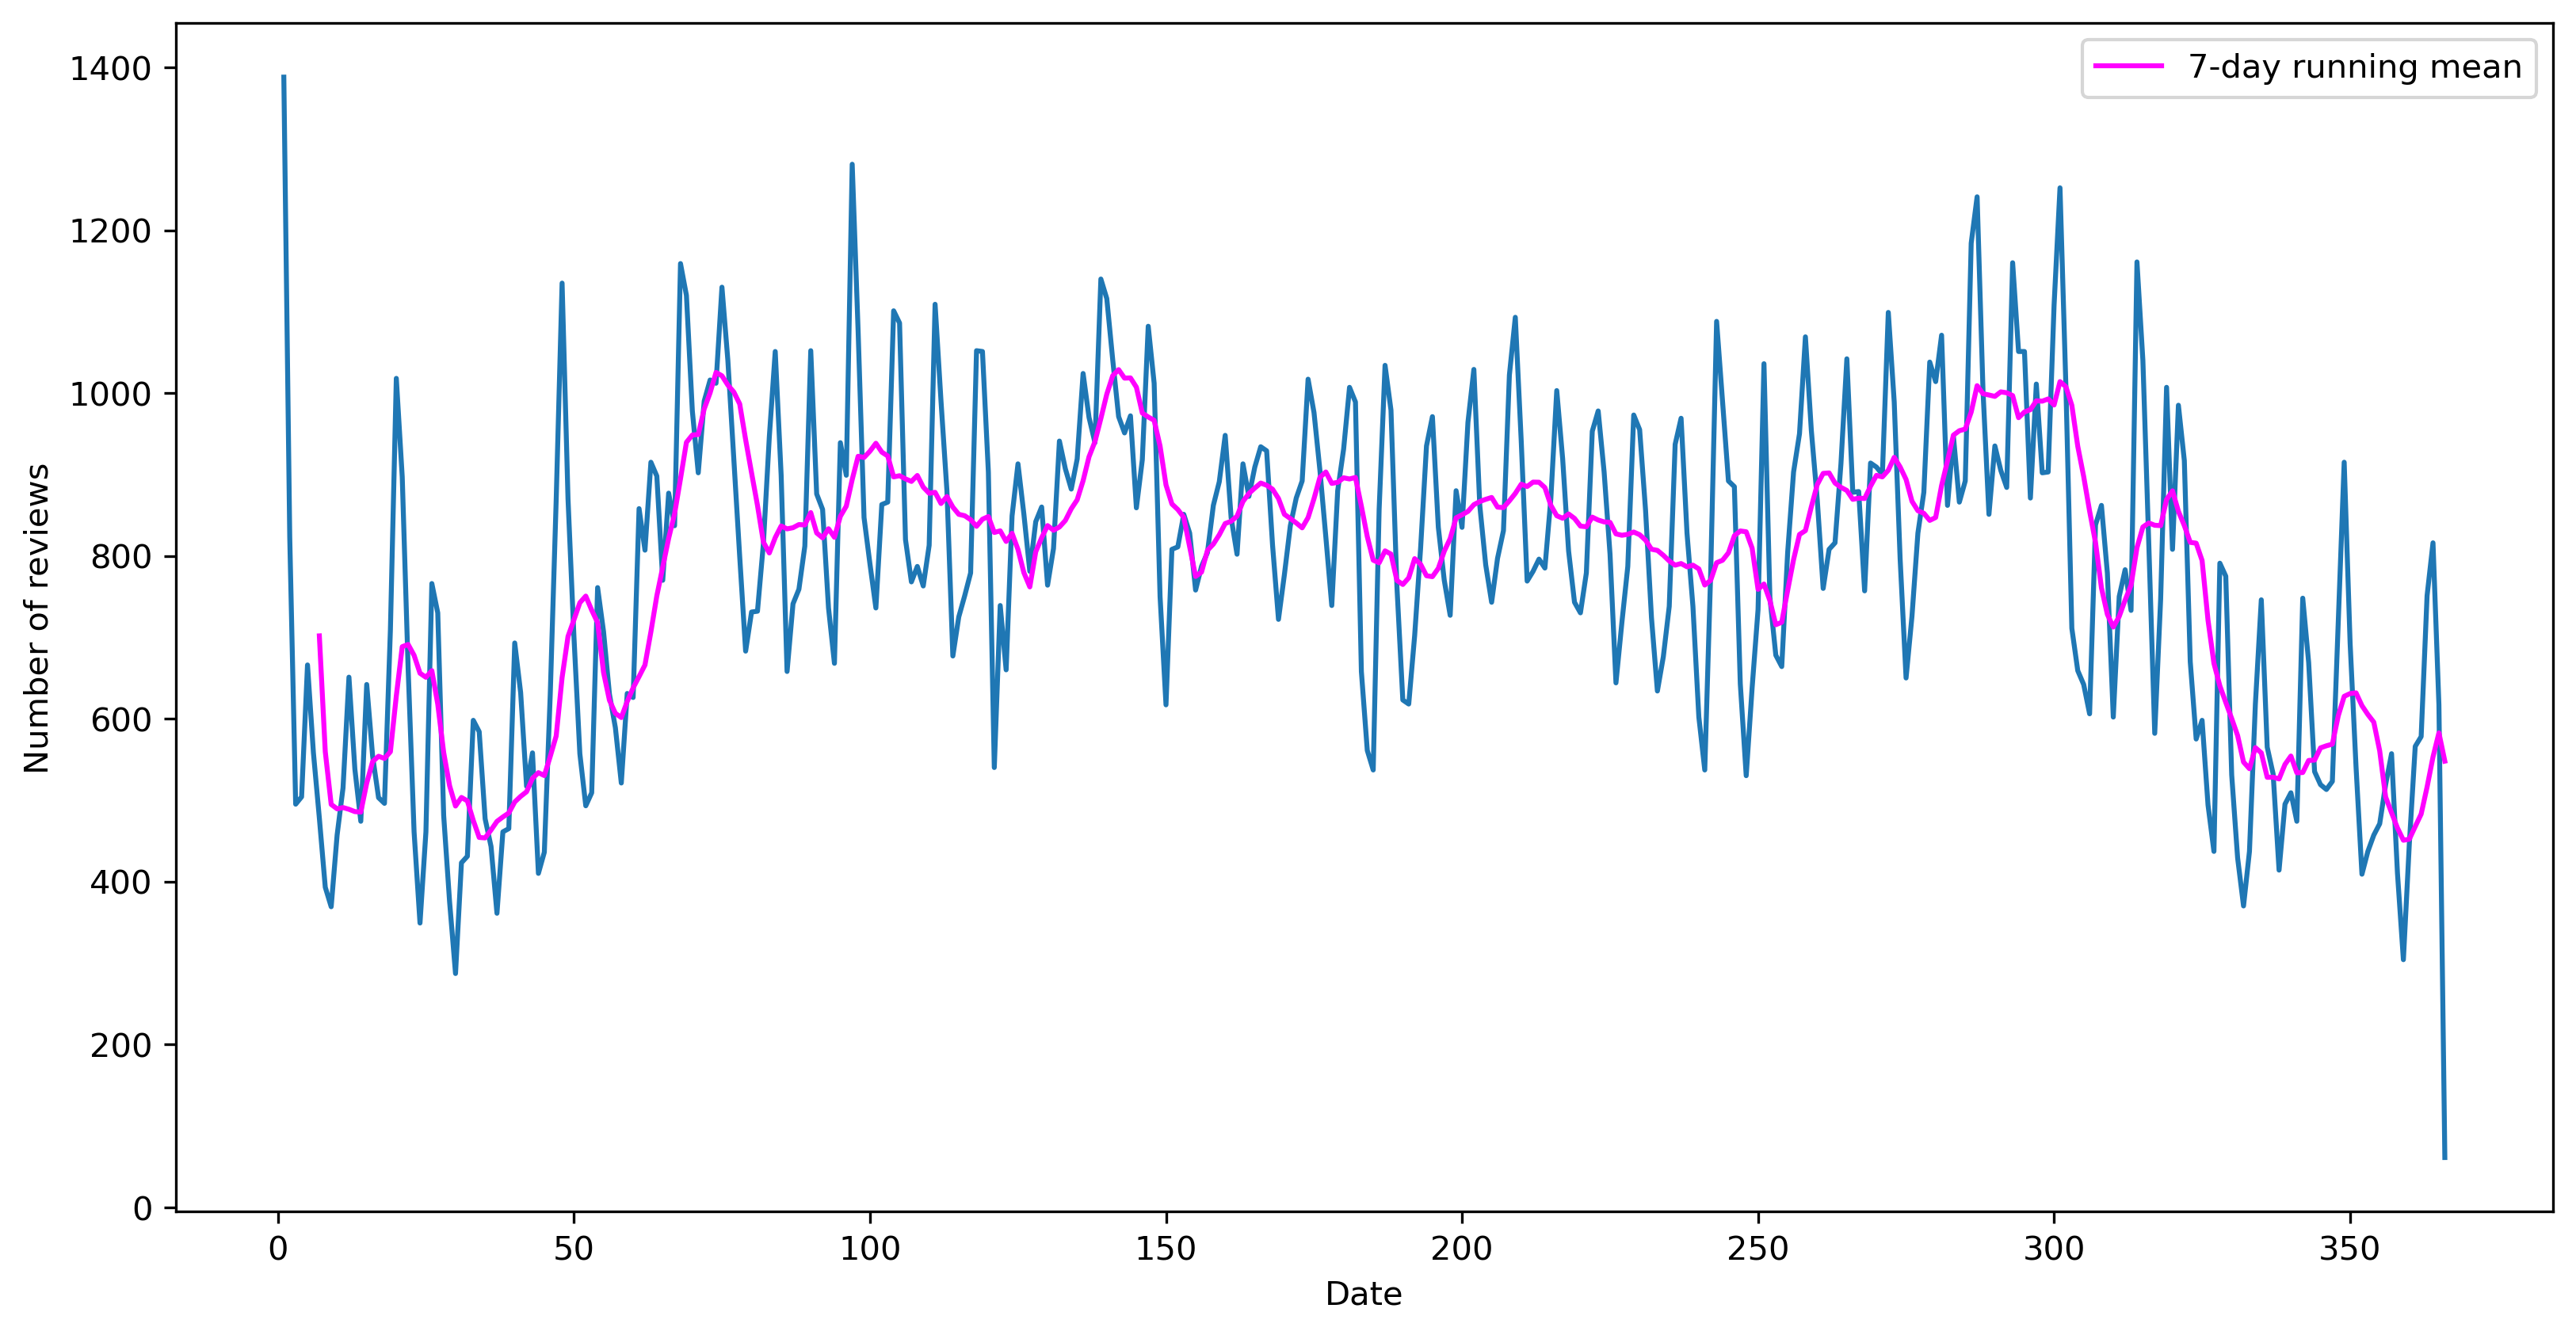

In [10]:
fig = plt.figure(figsize=(10,5),dpi=300)
ax = fig.add_axes([0,0,1,1])
ax.plot(counts_of_day['comments'], label='')
ax.plot(counts_of_day['comments'].rolling(window=7).mean(), label='7-day running mean', color='magenta')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Number of reviews');
fig.savefig('number_of_reviews_cycle.png', bbox_inches='tight')

In [11]:
print("Number of total reviews in Sep 2020:", len(sep_reviews))
print("Number of total reviews in Feb 2020:", len(feb_reviews))
print("Number of unique listing id in Sep 2020:", sep_reviews.listing_id.nunique())
print("Number of unique listing id in Feb 2020:", feb_reviews.listing_id.nunique())

Number of total reviews in Sep 2020: 287084
Number of total reviews in Feb 2020: 378519
Number of unique listing id in Sep 2020: 5546
Number of unique listing id in Feb 2020: 7374


## Task: Sentimental Analysis on review data, assign a score to each review comments. 

In [225]:
feb_reviews.sample(20, random_state=42) # note that 42 is the answer for everything :-)

,listing_id,id,date,reviewer_id,reviewer_name,comments,YearMonth
276798,21177503,517471224,2019-08-25,156306259,淑君,"很安静,干净也很舒服,有洗衣机也有烘干机,非常方便,就是距离地铁站远了点,距离公交车站点很近!",2019-8
95142,7361439,207608706,2017-10-29,68252436,Bill,The place was great! Nice backyard patio was ...,2017-10
328363,26294911,406689280,2019-01-30,41861454,Krista,"Good location, close to grocery store, 10 minu...",2019-1
251336,19093209,208486909,2017-11-01,27367586,Carina,Mike's house is lovely and has everything you ...,2017-11
210343,16415014,176333519,2017-07-30,35157428,Dean,Great bed. Great room. Great place. Great h...,2017-7
118710,9116972,301118736,2018-08-03,96840746,Lisa,"Eric's place is so convenient to all you need,...",2018-8
120207,9213437,177079238,2017-08-01,32117038,Aline,Zeer aangename Bnb!,2017-8
193855,15620627,574616075,2019-12-08,178975953,Portia,If you are someone that is looking for a cute ...,2019-12
191426,15423210,448651400,2019-05-05,14910661,Gina,We had an great time at Rey’s place. It was pe...,2019-5
23679,1159439,144699115,2017-04-16,115843927,Gabriela,"A great, spacious, comfortable, private, beaut...",2017-4


The field of our interest is comments that contains the textual comments. To trasform it into review sentiments, I will use the publicly available pre-trained (<a href="http://www.nltk.org/_modules/nltk/sentiment/vader.html">Vader sentiment model based on NLTK</a> (<a href="http://www.nltk.org/howto/sentiment.html">here</a> is the detailed usage example):

In [232]:
test_sentence_1 = 'Room was nice. Room was not awful at all. I really liked it.'
test_sentence_2 = 'I detest this room. It was terrible. I will not stay there any longer.'

# calculates compound sentiment polarity of the sentence
vader_polarity_compound = lambda s: (SentimentIntensityAnalyzer().polarity_scores(s))['compound']

vader_polarity_compound(test_sentence_1), vader_polarity_compound(test_sentence_2)

(0.8112, -0.4767)

In [235]:
print("null comments in the dataset", feb_reviews.comments.isnull().sum())

null comments in the dataset 203


drop the rows with null comment 

In [261]:
feb_reviews.dropna(subset=['comments'], how='any', axis=0, inplace=True)
print("null comments in the dataset", feb_reviews.comments.isnull().sum())

null comments in the dataset 0


In [262]:
%%time

feb_reviews['polarity'] = feb_reviews.comments.map(vader_polarity_compound)

! ls -lh *_reviews.h5

Illegal variable name.
-rw-r--r--  1 yingli  staff   120M Oct 27 12:33 feb_reviews.h5
CPU times: user 42min 46s, sys: 8.29 s, total: 42min 54s
Wall time: 43min 1s


In [263]:
# Create a new feature Month to consider the seasonality of the review
feb_reviews['Month']=feb_reviews.date.apply(lambda x: '{month}'.format(month=x.month))

In [292]:
feb_reviews.to_hdf('feb_reviews.h5', key='feb_reviews', mode='w')

In [16]:
#read hdf file
feb_reviews = pd.read_hdf('feb_reviews.h5', 'feb_reviews')

In [17]:
feb_reviews

,listing_id,id,date,reviewer_id,reviewer_name,comments,YearMonth,polarity,Month
0,3362,662,2009-01-21,6917,Robyn,Ayeh is a gracious and accommodating host. He...,2009-1,0.4215,1
1,3362,1099,2009-03-26,10492,Brian,"I stayed at Ayeh's place in March, and it was ...",2009-3,0.9618,3
2,3362,6300,2009-07-28,22668,Anthony,"My 14 y.o. niece, her best friend and I stayed...",2009-7,0.9287,7
3,3362,8387,2009-08-27,30379,Lina,We enjoyed the time with Ayeh in Washington ve...,2009-8,0.9689,8
4,3362,8451,2009-08-28,33059,Nicole,We also enjoyed our stay in DC while at Ayeh's...,2009-8,0.9743,8
...,...,...,...,...,...,...,...,...,...
378514,42260044,608785955,2020-02-21,89555071,Zac,"The home looks exactly like the pictures, very...",2020-2,0.9655,2
378515,42265430,608212944,2020-02-20,335725456,Tatiane,The host canceled this reservation 9 days befo...,2020-2,0.0000,2
378516,42291593,607859868,2020-02-19,143401312,Stephanie,The host canceled this reservation 56 days bef...,2020-2,0.0000,2
378517,42331238,607325479,2020-02-17,326183830,Mr,"Horrible experience!!!\nMy wife and I booked, ...",2020-2,-0.9430,2


Plotting the histogram of review intensities reveals the following peculiarities:

huge asymmetry between positive and negative reviews

As the development of sharing economy and the rise of Airbnb, a number of researchers and business journalists (e.g., Ho, 2015; Fradkin, Grewal, Holtz, & Pearson, 2015; Yannopoulou etal, 2013; Zekanovic-Korona & Grzunov, 2014; Zervas et al, 2015) have paid attention to this extraordinarily positive skew of Airbnb’s ratings. The possible reasons include the sociocultural factors of politeness and courtesy, as well as fear or retaliation, and concern about one’s online identity being linked to negative comments (Bridges, J., & Vásquez, C.,2018).

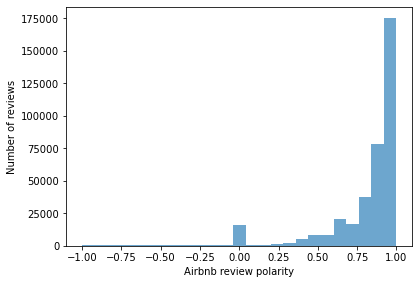

In [18]:
plt.hist(feb_reviews.polarity, bins=25, alpha=0.65)
plt.xlabel('Airbnb review polarity')
plt.ylabel('Number of reviews')
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.12)
plt.savefig('airbnb_reviews_polarity.png')

Close look at the histogram of negative reviews

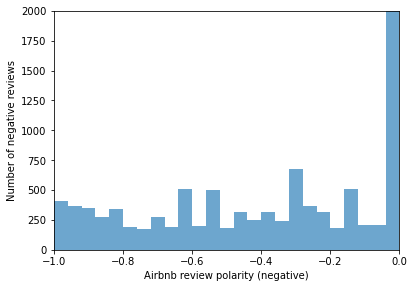

In [19]:
plt.hist(feb_reviews.polarity, bins=50, alpha=0.65)
plt.xlim([-1.00, 0.00])
plt.ylim([0, 2000])
plt.xlabel('Airbnb review polarity (negative)')
plt.ylabel('Number of negative reviews')
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.12)
plt.savefig('airbnb_reviews_negative_polarity.png')

In [20]:
feb_reviews[feb_reviews.polarity == 0.0].comments.head(30)

68     Appartement très accueillant. Nous n'avons pas...
125    Very spacious accommodations and close to ever...
135                                                    .
160    Lots of room, close to central DC and lots of ...
185    Nous avons séjourné très brièvement à Washingt...
217                                           性价比高,很好的设施
257                                          房间不错,住的很开心｡
263    The host canceled this reservation the day bef...
270    Sheila est très gentille, la chambre est très ...
449    The reservation was canceled 10 days before ar...
456    A very suitable place if you have your own tra...
480    房子就在华盛顿市内 开车到白宫只要20分钟 很方便 有2间卧室 还有一个大起居室可以打开沙发...
482    家庭旅馆,下面几点个人意见:\n1､房间\n小别墅,入住半截在地面以上的地下室,主人楼上｡房...
492                         安东尼热情,但是房间由于地下室,霉味较重,条件还是差点｡
507                                Picture is overrated 
509    Muy Amplio, fácil de llegar y acceder a la cui...
517    The host canceled this reservation 53 days bef...
537                          산드

In [21]:
list(feb_reviews[feb_reviews.polarity > 0.9995].comments)

['Every host on this web should be like them! Perfect stay! It was my first stay with Airbnb ( I even never stayed at the bed& breakfast style accommodations). I usually stay in an excellent 3-4 stars hotels. My friends was telling me how cool this website so I decided to give a try. Certainly, it was a VERY pleasant surprise. I am a bit shy person when it comes to my privacy or meeting a new people (forget about living with them lol), but I decided to step out of my comfort zone. Honestly, just because I was curious how Airbnb works. Ok. Let me break it down for you:\n1)   Location, location location… This place is not far from all main attractions. It’s an easy 25 minutes walking distance (unless you have a small kids under 7-8 y old). Take 9 NW St down and enjoy the walk through beautiful streets.\n2)  Safe. Neighborhood is clean and very pleasant to walk. Overall,  it’s a good area.\n3)   Clean house and a very charming old house with a character. They also have separate house on a

In [22]:
list(feb_reviews[feb_reviews.polarity < -0.97].comments)

["Nice family and lovley daughters\r\nbut the house was dirty. \r\nBecause of the dirt and grime in the kitchen we could not even make a cup of tea in the morning.\r\n i am sorry but after reading the past reviews We decided to book a place and this will be my last time in vita's Hide Away \r\n when we orderd a taxi we waited for more then Two hours and when i calld the again  they said that thair drivers don't to come because of the Dangerous and poor neighborhood and  that was not in the previous reviews.\r\nFor someone like me that  Came with his daughter outside the United States and  does not know Washington  this experience is not pleasant to experience and maybe a little scary and should have written on web that  the neighborhood is dangerous neighborhood",
 'Unser Aufenthalt in Washington war klasse. Serge war zwar nicht zu Hause, aber wir hatten ständig Mailkontakt.\r\nDas Zimmer ist schön,  geräumig, hell ( mit Vorhang ) , ruhig und  Klimaanlage. Das Bad nebenan ist klein,abe

### identify the language in which each review is written in and then remove any non-English reviews.

publicly available pre-trained Vader sentiment model based on NLTK is used to predict the sentiment polarity of recent reviews for Airbnb listings from DC. The model describes the sentiment polarity of English-written reviews fairly well but does not generalise for other common languages (German, French, Spanish etc.). So I also remove the comments that are not written in English. 

In [23]:
#pip install fasttext

###  Task: Create a new feature: number of reviews per listing ID, per month, this is going to be used as the target variable in the prediction model

In [24]:
feb_reviews.date = pd.to_datetime(feb_reviews.date) 
feb_reviews['YearMonth'] = feb_reviews.date.apply(lambda x: '{year}-{month}'.format(year=x.year, month=x.month))
df_review_number = feb_reviews.groupby(['listing_id','YearMonth']).comments.count().reset_index()
df_review_polarity = feb_reviews.groupby(['listing_id','YearMonth']).polarity.mean().reset_index()

In [36]:
df_review = pd.merge(df_review_number, df_review_polarity)
df_review
df_review = df_review.rename(columns={"comments": "number", "polarity": "score"})

In [37]:
df_review.to_csv('review_stat_byID_byYearMonth.csv',index=False)

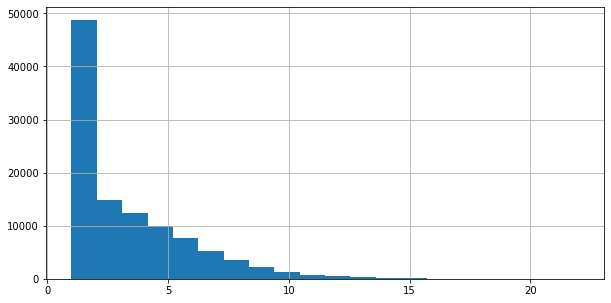

In [38]:
df_review.number.hist(figsize=(10,5), bins=20)

In [44]:
df_review[df_review['YearMonth'] == '2019-5'].sort_values('number',ascending=True)

,listing_id,YearMonth,number,score
64,3362,2019-5,1,0.000000
64486,16690169,2019-5,1,0.450900
64511,16693423,2019-5,1,-0.177900
64720,16724221,2019-5,1,0.709600
65142,16769813,2019-5,1,0.937600
...,...,...,...,...
15177,2833952,2019-5,14,0.883007
82931,21962401,2019-5,14,0.694014
81092,21423241,2019-5,16,0.812800
99460,30394567,2019-5,16,0.883713
